## Cloning Data from GitHub repo

In [0]:
import os,shutil
!git clone https://github.com/juhitiwari/SignDataset.git

Cloning into 'SignDataset'...
remote: Enumerating objects: 87031, done.
remote: Counting objects: 100% (87031/87031), done.
remote: Compressing objects: 100% (87031/87031), done.
remote: Total 87031 (delta 0), reused 87031 (delta 0), pack-reused 0
Receiving objects: 100% (87031/87031), 1.01 GiB | 30.54 MiB/s, done.
Checking out files: 100% (87000/87000), done.


In [0]:
os.chdir('/content/SignDataset')

In [0]:
!ls

A  D	F  I  L  nothing  Q  SignDataset  test	 V	     X
B  del	G  J  M  O	  R  space	  train  validation  Y
C  E	H  K  N  P	  S  T		  U	 W	     Z


In [0]:
base_dir = '/content/SignDataset'

validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)


In [0]:
test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

In [0]:
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)


In [0]:
classes=['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','space','nothing','del']

In [0]:
for c in classes:
  train_c_dir = os.path.join(train_dir, c)
  os.mkdir(train_c_dir)

In [0]:
for c in classes:
  validation_c_dir = os.path.join(validation_dir, c)
  os.mkdir(validation_c_dir)

In [0]:
for c in classes:
  test_c_dir = os.path.join(test_dir, c)
  os.mkdir(test_c_dir)

In [0]:
os.getcwd()

'/content/SignDataset'

In [0]:
from tqdm import tqdm
for c in classes:
    fnames = [c+'{}.jpg'.format(i) for i in range(1,2201)]
    for fname in tqdm(fnames):
        src = os.path.join("/content/SignDataset/"+c, fname)
        dst = os.path.join("/content/SignDataset/train/"+c, fname)
        #print(src)
        #print(dst)
        #os.mkdir("/content/SignDataset/train/"+c)
        shutil.copyfile(src, dst)

100%|██████████| 2200/2200 [00:00<00:00, 7574.60it/s]


In [0]:
for c in classes:
    fnames = [c+'{}.jpg'.format(i) for i in range(2201,2601)]
    for fname in tqdm(fnames):
        src = os.path.join("/content/SignDataset/"+c, fname)
        dst = os.path.join("/content/SignDataset/validation/"+c, fname)
        #print(src)
        #print(dst)
        shutil.copyfile(src, dst)

100%|██████████| 400/400 [00:00<00:00, 7628.05it/s]


In [0]:
for c in classes:
    fnames = [c+'{}.jpg'.format(i) for i in range(2601,3001)]
    for fname in tqdm(fnames):
        src = os.path.join("/content/SignDataset/"+c, fname)
        dst = os.path.join("/content/SignDataset/test/"+c, fname)
        #print(src)
        #print(dst)
        shutil.copyfile(src, dst)

100%|██████████| 400/400 [00:00<00:00, 8014.80it/s]


## Using pre-trained VGG-16 model for feature extraction

In [0]:
import keras
import numpy as np
from keras.applications import VGG16
conv_base = VGG16(weights='imagenet',
include_top=False,
input_shape=(150, 150, 3))

In [0]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [0]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(29, activation='softmax'))

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 29)                7453      
Total params: 16,819,549
Trainable params: 2,104,861
Non-trainable params: 14,714,688
_________________________________________________________________


In [0]:
conv_base.trainable = False  #freezing all layers of the vgg16 model

In [0]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator( rescale=1./255)
test_datagen = ImageDataGenerator( rescale=1./255)

In [0]:
train_datagen = train_datagen.flow_from_directory(train_dir,target_size=(150,150)
                                                    ,batch_size=100,class_mode='categorical')
val_datagen = test_datagen.flow_from_directory(validation_dir,target_size=(150,150)
                                                    ,batch_size=100,class_mode='categorical')
test_datagen = test_datagen.flow_from_directory(test_dir,target_size=(150,150)
                                                    ,batch_size=100,class_mode='categorical')

Found 63800 images belonging to 29 classes.
Found 11600 images belonging to 29 classes.
Found 11600 images belonging to 29 classes.


In [0]:
model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
loss='categorical_crossentropy',
metrics=['acc'])
history = model.fit_generator(
train_datagen,
steps_per_epoch=678,
epochs=7,
validation_data=val_datagen,
validation_steps=116)

Epoch 1/7
678/678 [==============================] - 374s 552ms/step - loss: 2.0369 - acc: 0.5222 - val_loss: 2.0275 - val_acc: 0.5352
Epoch 2/7
678/678 [==============================] - 373s 550ms/step - loss: 0.9898 - acc: 0.7912 - val_loss: 1.5416 - val_acc: 0.6341
Epoch 3/7
678/678 [==============================] - 373s 550ms/step - loss: 0.6076 - acc: 0.8789 - val_loss: 1.3091 - val_acc: 0.6848
Epoch 4/7
678/678 [==============================] - 373s 550ms/step - loss: 0.4213 - acc: 0.9184 - val_loss: 1.1377 - val_acc: 0.7109
Epoch 5/7
678/678 [==============================] - 373s 550ms/step - loss: 0.3144 - acc: 0.9405 - val_loss: 1.0275 - val_acc: 0.7307
Epoch 6/7
678/678 [==============================] - 373s 550ms/step - loss: 0.2465 - acc: 0.9549 - val_loss: 0.9589 - val_acc: 0.7433
Epoch 7/7
678/678 [==============================] - 373s 550ms/step - loss: 0.1960 - acc: 0.9651 - val_loss: 0.9038 - val_acc: 0.7497


In [0]:
test_generator = test_datagen.flow_from_directory(test_dir, target_size = (150, 150), batch_size = 100, class_mode = 'categorical')
test_loss, test_acc = model.evaluate_generator(test_generator,steps=116)
test_loss, test_acc

Found 11600 images belonging to 29 classes.


(0.5951126022585507, 0.8140517226580916)

In [0]:

model.save('deploy.h5')

In [0]:
pred=model.predict(test_features)
pred

array([[1.9216537e-03, 2.9802322e-08, 0.0000000e+00, ..., 4.1723251e-07,
        0.0000000e+00, 2.3841858e-07],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [5.9604645e-08, 1.0907650e-05, 5.9604645e-08, ..., 2.9802322e-08,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 1.0694563e-03, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 2.9802322e-08, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)

In [0]:
y_test=[]
for i in range(11600):
  y_test.append(np.argmax(test_labels[i]))

In [0]:
y_pred=[]
for i in range(11600):
  y_pred.append(np.argmax(pred[i]))

In [0]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer

In [0]:

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
  lb = LabelBinarizer()
  lb.fit(y_test)
  y_test = lb.transform(y_test)
  y_pred = lb.transform(y_pred)
  return roc_auc_score(y_test, y_pred, average=average)


In [0]:
multiclass_roc_auc_score(y_test,y_pred)

0.9032589285714286

In [0]:
K = [i for i in y_test if i==10]
len(K)

400

In [0]:
Kp = [i for i in y_pred if i==10]
len(Kp)

100

In [0]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

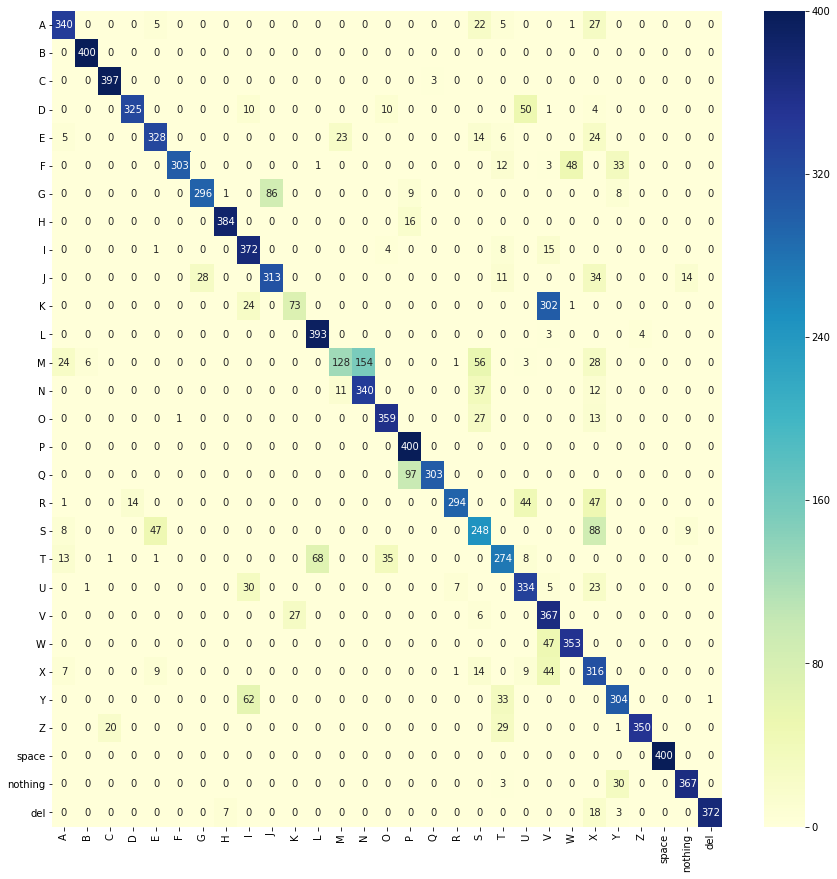

In [0]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index = classes,
                  columns = classes)
plt.figure(figsize = (15,15))
sns.heatmap(df_cm,annot=True, fmt='1.0f', cmap='YlGnBu')

In [0]:
from google.colab import drive
drive.mount('/content/drive')
#drive.mount('/content/SignDataset')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
os.chdir('/content/drive/My Drive')

In [0]:
np.save('TrainFeatures',train_features)
np.save('TrainLabels',train_labels)

In [0]:
train_features = np.load('TrainFeatures.npy')
train_labels = np.load('TrainLabels.npy')




100%|█████████▉| 578/580 [00:59<00:00, 12.44it/s]

In [0]:
model.save('pikapi.h5')

In [0]:
from keras.models import load_model
model = load_model('pikapi.h5')

In [0]:
from keras.utils import plot_model
plot_model(model, to_file='pikapi.png')

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
dense_1 (Dense)              (None, 4, 4, 256)         131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 4, 256)         0         
_________________________________________________________________
dense_2 (Dense)              (None, 4, 4, 29)          7453      
Total params: 14,853,469
Trainable params: 14,853,469
Non-trainable params: 0
_________________________________________________________________


In [0]:
from sklearn.metrics import classification_report
cr = classification_report(y_pred, y_test, target_names=classes)
print(cr)

              precision    recall  f1-score   support

           A       0.85      0.85      0.85       398
           B       1.00      0.98      0.99       407
           C       0.99      0.95      0.97       418
           D       0.81      0.96      0.88       339
           E       0.82      0.84      0.83       391
           F       0.76      1.00      0.86       304
           G       0.74      0.91      0.82       324
           H       0.96      0.98      0.97       392
           I       0.93      0.75      0.83       498
           J       0.78      0.78      0.78       399
           K       0.18      0.73      0.29       100
           L       0.98      0.85      0.91       462
           M       0.32      0.79      0.46       162
           N       0.85      0.69      0.76       494
           O       0.90      0.88      0.89       408
           P       1.00      0.77      0.87       522
           Q       0.76      0.99      0.86       306
           R       0.73    

In [0]:


def show_values(pc, fmt="%.2f", **kw):
 
    pc.update_scalarmappable()
    ax = pc.axes
    for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)


def cm2inch(*tupl):
    '''
    Specify figure size in centimeter in matplotlib
    Source: https://stackoverflow.com/a/22787457/395857
    By gns-ank
    '''
    inch = 2.54
    if type(tupl[0]) == tuple:
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)


def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels, figure_width=40, figure_height=20, correct_orientation=False, cmap='RdBu'):
    '''
    Inspired by:
    - https://stackoverflow.com/a/16124677/395857 
    - https://stackoverflow.com/a/25074150/395857
    '''

    # Plot it out
    fig, ax = plt.subplots()    
    #c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap='RdBu', vmin=0.0, vmax=1.0)
    c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap=cmap)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)

    # set tick labels
    #ax.set_xticklabels(np.arange(1,AUC.shape[1]+1), minor=False)
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)

    # set title and x/y labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)      

    # Remove last blank column
    plt.xlim( (0, AUC.shape[1]) )

    # Turn off all the ticks
    ax = plt.gca()    
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    # Add color bar
    plt.colorbar(c)

    # Add text in each cell 
    show_values(c)

    # Proper orientation (origin at the top left instead of bottom left)
    if correct_orientation:
        ax.invert_yaxis()
        ax.xaxis.tick_top()       

    # resize 
    fig = plt.gcf()
    #fig.set_size_inches(cm2inch(40, 20))
    #fig.set_size_inches(cm2inch(40*4, 20*4))
    fig.set_size_inches(cm2inch(figure_width, figure_height))



def plot_classification_report(classification_report, title='Classification report ', cmap='RdBu'):
    '''
    Plot scikit-learn classification report.
    Extension based on https://stackoverflow.com/a/31689645/395857 
    '''
    lines = classification_report.split('\n')

    classes = []
    plotMat = []
    support = []
    class_names = []
    for line in lines[2 : (len(lines) - 2)]:
        t = line.strip().split()
        if len(t) < 2: continue
        classes.append(t[0])
        print(t)
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        print(v)
        plotMat.append(v)

    print('plotMat: {0}'.format(plotMat))
    print('support: {0}'.format(support))

    xlabel = 'Metrics'
    ylabel = 'Classes'
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup) for idx, sup  in enumerate(support)]
    figure_width = 25
    figure_height = len(class_names) + 7
    correct_orientation = False
    heatmap(np.array(plotMat), title, xlabel, ylabel, xticklabels, yticklabels, figure_width, figure_height, correct_orientation, cmap=cmap)


def main():
    sampleClassificationReport = """precision    recall  f1-score   support

           A       0.85      0.85      0.85       398
           B       1.00      0.98      0.99       407
           C       0.99      0.95      0.97       418
           D       0.81      0.96      0.88       339
           E       0.82      0.84      0.83       391
           F       0.76      1.00      0.86       304
           G       0.74      0.91      0.82       324
           H       0.96      0.98      0.97       392
           I       0.93      0.75      0.83       498
           J       0.78      0.78      0.78       399
           K       0.18      0.73      0.29       100
           L       0.98      0.85      0.91       462
           M       0.32      0.79      0.46       162
           N       0.85      0.69      0.76       494
           O       0.90      0.88      0.89       408
           P       1.00      0.77      0.87       522
           Q       0.76      0.99      0.86       306
           R       0.73      0.97      0.84       303
           S       0.62      0.58      0.60       424
           T       0.69      0.72      0.70       381
           U       0.83      0.75      0.79       448
           V       0.92      0.47      0.62       787
           W       0.88      0.88      0.88       403
           X       0.79      0.50      0.61       634
           Y       0.76      0.80      0.78       379
           Z       0.88      0.99      0.93       354
       space       1.00      1.00      1.00       400
     nothing       0.92      0.94      0.93       390
         del       0.93      1.00      0.96       373"""


    plot_classification_report(sampleClassificationReport)
    plt.savefig('test_plot_classif_report.png', dpi=200, format='png', bbox_inches='tight')
    plt.close()

if __name__ == "__main__":
    main()

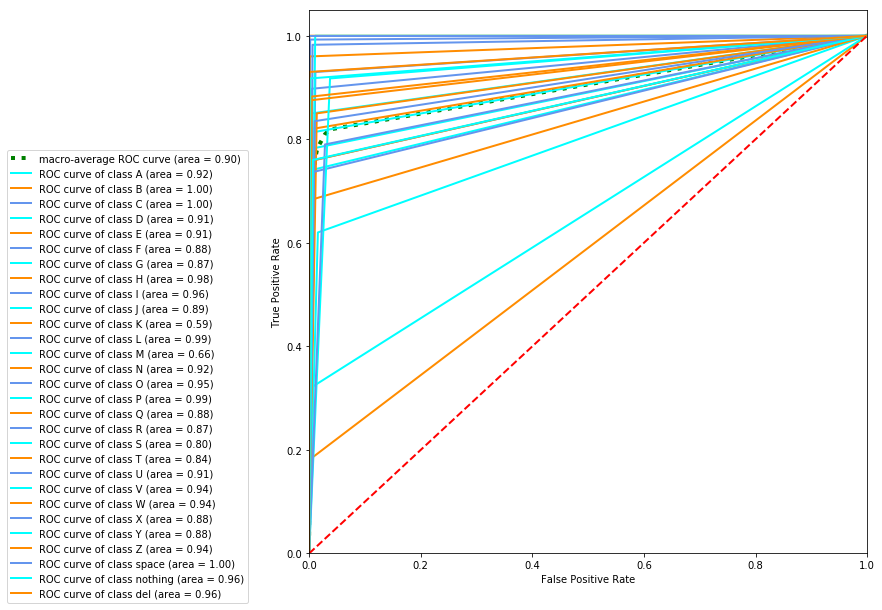

In [0]:
from sklearn.metrics import roc_curve,auc
from scipy import interp
from itertools import cycle
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 29
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(np.array(pd.get_dummies(y_test))[:, i], np.array(pd.get_dummies(y_pred))[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

lw=2
plt.figure(figsize=(10,10))
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='green', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classes[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--',color='red', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right", bbox_to_anchor=(-0.1,-0.1))
plt.show()

